# Import lib and loading data

In [1]:
import os
import itertools
import joblib
import json
import random
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from collections import deque

2025-11-20 10:06:07.227576: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 10:06:07.230840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 10:06:07.423546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 10:06:09.789768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
file_path = 'WELL-00025_20200629194141.parquet'

In [4]:
df = pd.read_parquet(file_path)

In [5]:
df.head()

,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,PT-P,P-TPT,QBS,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT,class,state
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-29 19:41:41,NaN,49.06404,1.0,NaN,NaN,0.0,0.0,1.0,1.0,NaN,...,NaN,11161080.0,NaN,2.874838,NaN,32.34652,61.25951,44.04545,<NA>,<NA>
2020-06-29 19:41:42,NaN,49.06509,1.0,NaN,NaN,0.0,0.0,1.0,1.0,NaN,...,NaN,11162970.0,NaN,2.874975,NaN,32.34331,61.25951,44.02964,<NA>,<NA>
2020-06-29 19:41:43,NaN,49.06613,1.0,NaN,NaN,0.0,0.0,1.0,1.0,NaN,...,NaN,11164860.0,NaN,2.875113,NaN,32.34011,61.25957,44.01382,<NA>,<NA>
2020-06-29 19:41:44,NaN,49.06717,1.0,NaN,NaN,0.0,0.0,1.0,1.0,NaN,...,NaN,11166760.0,NaN,2.875250,NaN,32.33691,61.25964,43.99800,<NA>,<NA>
2020-06-29 19:41:45,NaN,49.06821,1.0,NaN,NaN,0.0,0.0,1.0,1.0,NaN,...,NaN,11168650.0,NaN,2.875388,NaN,32.33370,61.25970,43.98219,<NA>,<NA>


# Data preprocessing

In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 722192 entries, 2020-06-29 19:41:41 to 2020-07-08 04:18:12
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ABER-CKGL      0 non-null       float64
 1   ABER-CKP       720873 non-null  float64
 2   ESTADO-DHSV    722130 non-null  float64
 3   ESTADO-M1      594562 non-null  float64
 4   ESTADO-M2      474723 non-null  float64
 5   ESTADO-PXO     722130 non-null  float64
 6   ESTADO-SDV-GL  720956 non-null  float64
 7   ESTADO-SDV-P   720956 non-null  float64
 8   ESTADO-W1      722087 non-null  float64
 9   ESTADO-W2      477288 non-null  float64
 10  ESTADO-XO      722130 non-null  float64
 11  P-ANULAR       720956 non-null  float64
 12  P-JUS-BS       0 non-null       float64
 13  P-JUS-CKGL     0 non-null       float64
 14  P-JUS-CKP      721482 non-null  float64
 15  P-MON-CKGL     0 non-null       float64
 16  P-MON-CKP      721482 non-null  float64


In [7]:
df['class'].unique()

<IntegerArray>
[<NA>, 0, 108, 8]
Length: 4, dtype: Int16

In [8]:
cols_to_drop = ['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2', 'ESTADO-PXO', 'ESTADO-SDV-GL',
       'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2', 'ESTADO-XO', 'state']
df = df.drop(columns=cols_to_drop)

In [9]:
df.isnull().sum()

P-ANULAR         1236
P-JUS-BS       722192
P-JUS-CKGL     722192
P-JUS-CKP         710
P-MON-CKGL     722192
P-MON-CKP         710
P-MON-SDV-P    722192
P-PDG            1184
PT-P           722192
P-TPT            1236
QBS            722192
QGL              1255
T-JUS-CKP      722192
T-MON-CKP        1284
T-PDG            1184
T-TPT            1236
class            3600
dtype: int64

In [10]:
total_rows = len(df)
cols_to_drop = []
for col in df.columns:
    if df[col].isnull().sum() / total_rows > 0.4:
        cols_to_drop.append(col)
        
df = df.drop(columns=cols_to_drop)
df = df.dropna(subset=['class'])
df = df.dropna(subset=['P-MON-CKP'])

In [11]:
df.describe() # P_PDG, P_TPT, T_TPT, P-MON-CKP.

,P-ANULAR,P-JUS-CKP,P-MON-CKP,P-PDG,P-TPT,QGL,T-MON-CKP,T-PDG,T-TPT,class
count,7.185200e+05,7.185200e+05,7.185200e+05,7.185200e+05,7.185200e+05,7.185000e+05,718472.000000,718520.000000,718520.000000,718520.0
mean,2.169904e+07,1.812012e+06,8.492997e+06,4.656773e+07,2.064457e+07,4.820140e-01,24.482212,58.370401,9.216225,89.847052
std,1.458128e+06,1.078098e+05,3.234180e+06,5.692610e+06,3.783123e+06,1.104916e+00,4.165531,1.358105,13.684339,39.860102
min,1.005137e+07,-1.196814e+05,-2.370260e+05,3.131348e+07,8.360535e+06,1.954357e-25,-1.198569,57.305420,-0.162129,0.0
25%,2.147734e+07,1.774014e+06,9.378088e+06,4.845746e+07,2.145066e+07,1.954357e-25,22.495067,57.454290,3.112321,108.0
50%,2.186115e+07,1.789063e+06,9.395647e+06,4.891626e+07,2.182542e+07,1.954357e-25,24.485735,57.681205,3.175836,108.0
75%,2.218018e+07,1.823738e+06,9.468602e+06,4.903094e+07,2.214383e+07,2.750711e-21,25.408152,58.759887,3.281870,108.0
max,2.744976e+07,1.011400e+07,2.024535e+07,4.909435e+07,3.050146e+07,4.310789e+00,36.060160,61.377690,44.629310,108.0


In [12]:
df.isnull().sum()

P-ANULAR      0
P-JUS-CKP     0
P-MON-CKP     0
P-PDG         0
P-TPT         0
QGL          20
T-MON-CKP    48
T-PDG         0
T-TPT         0
class         0
dtype: int64

# Feature Selection

<Axes: title={'center': 'Linear correlation coefs between all the features'}>

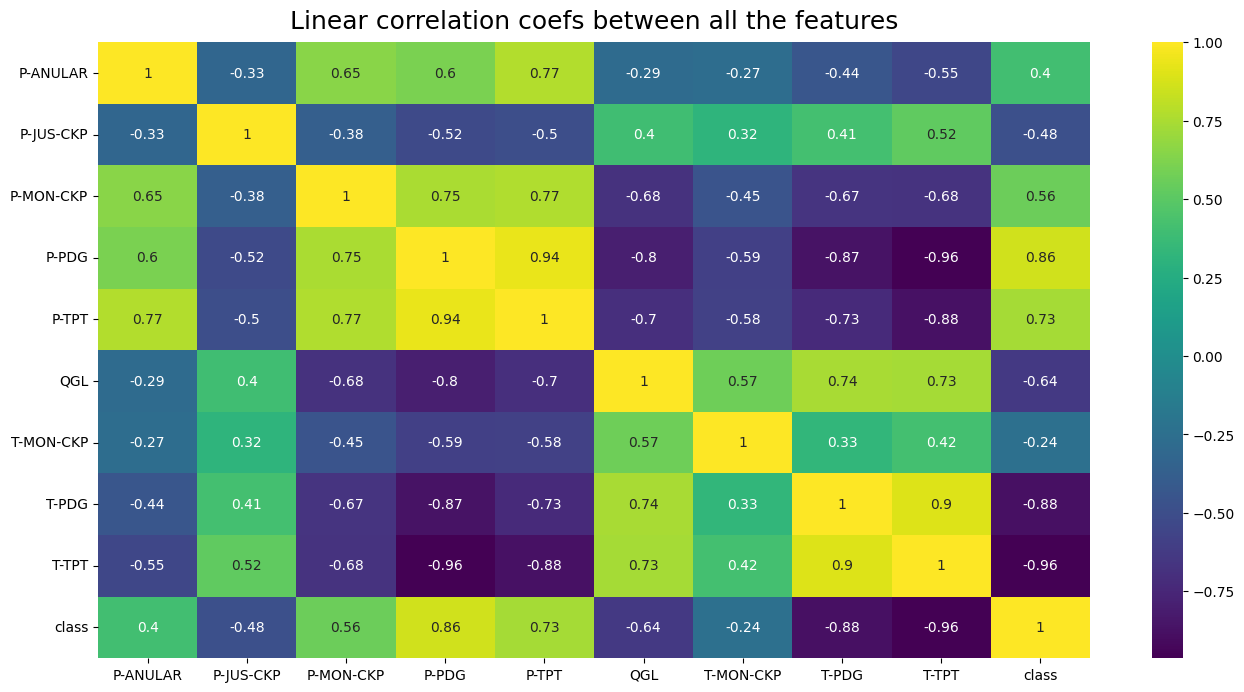

In [13]:
plt.figure(figsize=(16,8))
plt.title("Linear correlation coefs between all the features",fontsize=18,pad=10)
sns.heatmap(df.corr(), annot=True, cmap="viridis")

In [14]:
FINAL_FEATURES = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP']
df = df[FINAL_FEATURES + ['class']]

# Preparing data

In [15]:
normal_df = df[df['class'] == 0].copy()
anomalous_df = df[df['class'] != 0].copy()

train_split_index = int(len(normal_df) * 0.6)

train_df = normal_df.iloc[:train_split_index]
test_normal_df = normal_df.iloc[train_split_index:]

test_df = pd.concat([test_normal_df, anomalous_df]).sort_index()

# Drop the 'class' label from the training data
X_train = train_df.drop(columns=['class'])

# Keep the 'class' label in the test data for evaluation
X_test = test_df.drop(columns=['class'])
# Binarize labels: 0=normal, 1=anomaly
y_test = test_df['class'].apply(lambda x: 0 if x == 0 else 1)

In [16]:
def preprocess(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    joblib.dump(scaler, 'models/my_scaler.joblib')
    X_test_scaled = scaler.transform(X_test)
    noise_value = X_train_scaled.mean() * 0.0005
    X_train_noised = X_train_scaled + np.random.normal(0, noise_value, X_train_scaled.shape)
    return X_train_scaled, X_train_noised, X_test_scaled

In [17]:
X_train_proc, X_train_noised, X_test_proc = preprocess(X_train, X_test)

# Training model and using grid search to find optimize hyperparameters

In [18]:
if not os.path.exists('models'):
    os.makedirs('models')

In [19]:
def run_sliding_window_with_params(model, X_test_proc, window_size, rule_threshold=0.9):
    """
    Tests the model with a specific window_size and rule.
    """
    raw_predictions = model.predict(X_test_proc)
    raw_preds_binary = [1 if p == -1 else 0 for p in raw_predictions]

    rolling_series = pd.Series(raw_preds_binary)
    rolling_sum = rolling_series.rolling(window=window_size).sum()
    
    # Apply the rule (e.g., 9 out of 10)
    final_predictions = (rolling_sum >= (window_size * rule_threshold)).astype(int)
    
    # Fill the (window_size - 1) NaNs at the start
    final_predictions_filled = final_predictions.fillna(0).astype(int).tolist()
    
    return final_predictions_filled

In [20]:
def run_full_pipeline_for_grid(window_size, md, **model_params):
    # Huấn luyện mô hình chính xác
    if md == 'lof':
        # Truyền toàn bộ dict params
        model = train_lof_model_with_params(X_train_proc, **model_params)
    elif md == 'if':
        # Truyền toàn bộ dict params
        model = train_if_model_with_params(X_train_proc, **model_params)
    else:
        raise ValueError(f"Loại mô hình không xác định: {md}")
        
    # y_pred_ns = model.predict(X_test_proc)
    # y_pred_ns = [1 if p == -1 else 0 for p in y_pred_ns]
    # print(classification_report(y_test, y_pred_ns))
    
    y_pred = run_sliding_window_with_params(model, X_test_proc, window_size)
    
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics = {
        'F1': f1,
        'ACC': acc,
        'PR': pr,
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'TP': int(tp)
    }
    return metrics

In [21]:
def find_the_best_hyperparams(results):
    results_df = pd.json_normalize(results)
    
    # We use 'metrics.F1' because that's how json_normalize flattens it
    best_results_sorted = results_df.sort_values(by='metrics.F1', ascending=False)
    
    # Print the top 5 best-performing models
    print("--- Top 5 Best Model Combinations (sorted by F1 score) ---")
    print(best_results_sorted.head())
    
    # Get the single best run as a dictionary
    best_run_dict = best_results_sorted.iloc[0].to_dict()
    print("\n--- Details of The Single Best Run ---")
    print(best_run_dict)
    return best_run_dict

## Evaluation function

In [22]:
def evaluate_anomaly_model_raw(model_path, scaler_path, X_test, y_test, model_name):
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

    X_test_scaled = scaler.transform(X_test)
    
    y_pred_raw = model.predict(X_test_scaled)
    
    # Convert to binary labels: -1 -> 1 (Anomaly), 1 -> 0 (Normal)
    y_pred_binary = [1 if p == -1 else 0 for p in y_pred_raw]
    
    f1 = f1_score(y_test, y_pred_binary, zero_division=0)
    acc = accuracy_score(y_test, y_pred_binary)
    pr = precision_score(y_test, y_pred_binary, zero_division=0)
    rec = recall_score(y_test, y_pred_binary, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    
    metrics = {
        'Model': model_name,
        'F1': f1,
        'ACC': acc,
        'PR': pr,
        'REC': rec,
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'TP': int(tp)
    }
    
    return metrics

In [23]:
def evaluate_anomaly_model_slicing_window(model_path, scaler_path, X_test, y_test, model_name, window_size=15):
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

    X_test_proc = scaler.transform(X_test)
    
    y_pred = run_sliding_window_with_params(model, X_test_proc, window_size)
    
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics = {
        'Model': model_name,
        'F1': f1,
        'ACC': acc,
        'PR': pr,
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'TP': int(tp)
    }
    return metrics

## LOF model:

In [24]:
def train_lof_model_with_params(X_train_proc, **model_params):
    """
    Huấn luyện mô hình LOF bằng các tham số từ một dict.
    """
    lof = LocalOutlierFactor(
        n_neighbors=model_params['neighbors'], 
        metric=model_params['metric'],      
        contamination='auto',
        novelty=True
    )
    lof.fit(X_train_proc)
    return lof

In [25]:
def main_run_for_train_lof():
    """
    Xác định lưới tham số và chạy pipeline grid search đầy đủ
    cho mô hình Local Outlier Factor (LOF).
    """
    param_grid = {
        'n_neighbors': [15, 25, 35, 45],
        'metric': ['euclidean', 'minkowski'], 
        'window_size': [5, 10, 15]
    }
    
    results = []
    
    # Tạo danh sách tất cả các kết hợp
    all_combos = list(itertools.product(
        param_grid['n_neighbors'],
        param_grid['metric'],
        param_grid['window_size']
    ))
    
    for neighbors, metric, window_size in tqdm(all_combos):
        print(neighbors, metric, window_size)
        
        metrics = run_full_pipeline_for_grid(
            window_size=window_size,
            md='lof',  
            
            neighbors=neighbors,
            metric=metric
        )
        
        if metrics is not None:
            results.append({
                'n_neighbors': neighbors,
                'window_size': window_size,
                'metric': metric,
                'metrics': metrics
            })
            
    return results

In [26]:
results_lof = main_run_for_train_lof()

  0%|                                                                                          | 0/24 [00:00<?, ?it/s]

15 euclidean 5


  4%|███▍                                                                              | 1/24 [00:06<02:24,  6.27s/it]

15 euclidean 10


  8%|██████▊                                                                           | 2/24 [00:10<01:50,  5.02s/it]

15 euclidean 15


 12%|██████████▎                                                                       | 3/24 [00:16<01:56,  5.57s/it]

15 minkowski 5


 17%|█████████████▋                                                                    | 4/24 [00:22<01:52,  5.64s/it]

15 minkowski 10


 21%|█████████████████                                                                 | 5/24 [00:28<01:47,  5.67s/it]

15 minkowski 15


 25%|████████████████████▌                                                             | 6/24 [00:33<01:42,  5.68s/it]

25 euclidean 5


 29%|███████████████████████▉                                                          | 7/24 [00:40<01:43,  6.10s/it]

25 euclidean 10


 33%|███████████████████████████▎                                                      | 8/24 [00:49<01:51,  6.99s/it]

25 euclidean 15


 38%|██████████████████████████████▊                                                   | 9/24 [00:58<01:53,  7.57s/it]

25 minkowski 5


 42%|█████████████████████████████████▊                                               | 10/24 [01:07<01:51,  7.99s/it]

25 minkowski 10


 46%|█████████████████████████████████████▏                                           | 11/24 [01:14<01:39,  7.64s/it]

25 minkowski 15


 50%|████████████████████████████████████████▌                                        | 12/24 [01:23<01:35,  7.97s/it]

35 euclidean 5


 54%|███████████████████████████████████████████▉                                     | 13/24 [01:33<01:36,  8.80s/it]

35 euclidean 10


 58%|███████████████████████████████████████████████▎                                 | 14/24 [01:42<01:27,  8.78s/it]

35 euclidean 15


 62%|██████████████████████████████████████████████████▋                              | 15/24 [01:53<01:24,  9.34s/it]

35 minkowski 5


 67%|██████████████████████████████████████████████████████                           | 16/24 [02:03<01:18,  9.77s/it]

35 minkowski 10


 71%|█████████████████████████████████████████████████████████▍                       | 17/24 [02:14<01:09, 10.00s/it]

35 minkowski 15


 75%|████████████████████████████████████████████████████████████▊                    | 18/24 [02:25<01:01, 10.22s/it]

45 euclidean 5


 79%|████████████████████████████████████████████████████████████████▏                | 19/24 [02:36<00:52, 10.49s/it]

45 euclidean 10


 83%|███████████████████████████████████████████████████████████████████▌             | 20/24 [02:50<00:46, 11.60s/it]

45 euclidean 15


 88%|██████████████████████████████████████████████████████████████████████▉          | 21/24 [03:02<00:35, 11.80s/it]

45 minkowski 5


 92%|██████████████████████████████████████████████████████████████████████████▎      | 22/24 [03:16<00:24, 12.50s/it]

45 minkowski 10


 96%|█████████████████████████████████████████████████████████████████████████████▋   | 23/24 [03:28<00:12, 12.40s/it]

45 minkowski 15


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [03:43<00:00,  9.29s/it]


In [27]:
print('lof model')
best_run_dict = find_the_best_hyperparams(results_lof)

n_neighbors_val = best_run_dict['n_neighbors']
metric_val = best_run_dict['metric']

model_lof = train_lof_model_with_params(
    X_train_proc, 
    neighbors=n_neighbors_val, # Bên trong hàm bạn dùng key 'neighbors'
    metric=metric_val          # Bên trong hàm bạn dùng key 'metric'
)

joblib.dump(model_lof, 'models/my_lof_model.joblib')

lof model
--- Top 5 Best Model Combinations (sorted by F1 score) ---
    n_neighbors  window_size     metric  metrics.F1  metrics.ACC  metrics.PR  \
23           45           15  minkowski    0.997798     0.995813    0.995606   
20           45           15  euclidean    0.997798     0.995813    0.995606   
17           35           15  minkowski    0.997678     0.995584    0.995366   
14           35           15  euclidean    0.997678     0.995584    0.995366   
8            25           15  euclidean    0.997415     0.995083    0.994844   

    metrics.TN  metrics.FP  metrics.FN  metrics.TP  
23       31490        2793           0      632813  
20       31490        2793           0      632813  
17       31337        2946           0      632813  
14       31337        2946           0      632813  
8        31003        3280           0      632813  

--- Details of The Single Best Run ---
{'n_neighbors': 45, 'window_size': 15, 'metric': 'minkowski', 'metrics.F1': 0.99779804622920

['models/my_lof_model.joblib']

### Evaluation without slicing window smoothing:

In [28]:
model_path = 'models/my_lof_model.joblib'
scaler_path =  'models/my_scaler.joblib'
evaluate_anomaly_model_raw(model_path, scaler_path, X_test, y_test, model_name = 'lof')

{'Model': 'lof',
 'F1': 0.9965143186937868,
 'ACC': 0.9933637737297181,
 'PR': 0.9930528529282531,
 'REC': 1.0,
 'TN': 29856,
 'FP': 4427,
 'FN': 0,
 'TP': 632813}

### Evaluation with slicing window smoothing to enhance efficiency

In [29]:
model_path = 'models/my_lof_model.joblib'
scaler_path =  'models/my_scaler.joblib'
evaluate_anomaly_model_slicing_window(model_path, scaler_path, X_test, y_test, model_name = 'lof')

{'Model': 'lof',
 'F1': 0.9977980462292034,
 'ACC': 0.9958131963015818,
 'PR': 0.995605768353351,
 'TN': 31490,
 'FP': 2793,
 'FN': 0,
 'TP': 632813}

## IF model:

In [30]:
def train_if_model_with_params(X_train_proc, **model_params):
    """
    Huấn luyện mô hình Isolation Forest bằng các tham số từ một dict.
    (Đây là hàm của bạn, đã được cập nhật)
    """
    if_model = IsolationForest(
        n_estimators=model_params['n_estimators'], 
        contamination=model_params['contamination'],
        max_samples=model_params['max_samples'],   
        random_state=42 
    )
    if_model.fit(X_train_proc)
    return if_model

In [31]:
def main_run_for_train_if():
    """
    Xác định lưới tham số và chạy pipeline grid search đầy đủ
    cho mô hình Isolation Forest.
    """
    param_grid = {
        'n_estimators': [50, 100, 200],      
        'contamination': ['auto', 0.01, 0.05], 
        'max_samples': ['auto', 0.75],      
        'window_size': [5, 10, 15]       
    }
    
    results = []
    
    # Tạo danh sách tất cả các kết hợp
    all_combos = list(itertools.product(
        param_grid['n_estimators'],
        param_grid['contamination'],
        param_grid['max_samples'],
        param_grid['window_size']
    ))
    
    for n_estimators, contamination, max_samples, window_size in tqdm(all_combos):
        
        print(n_estimators, contamination, max_samples, window_size)
        
        metrics = run_full_pipeline_for_grid(
            window_size=window_size,
            md='if', 
            
            n_estimators=n_estimators,
            contamination=contamination,
            max_samples=max_samples
        )
        
        if metrics is not None:
            results.append({
                'n_estimators': n_estimators,
                'contamination': contamination,
                'max_samples': max_samples,
                'window_size': window_size,
                'metrics': metrics
            })
            
    return results

In [32]:
results_if = main_run_for_train_if()

  0%|                                                                                          | 0/54 [00:00<?, ?it/s]

50 auto auto 5


  2%|█▌                                                                                | 1/54 [00:01<00:54,  1.03s/it]

50 auto auto 10


  4%|███                                                                               | 2/54 [00:02<00:54,  1.04s/it]

50 auto auto 15


  6%|████▌                                                                             | 3/54 [00:03<00:53,  1.04s/it]

50 auto 0.75 5


  7%|██████                                                                            | 4/54 [00:04<01:04,  1.28s/it]

50 auto 0.75 10


  9%|███████▌                                                                          | 5/54 [00:06<01:08,  1.40s/it]

50 auto 0.75 15


 11%|█████████                                                                         | 6/54 [00:07<01:10,  1.46s/it]

50 0.01 auto 5


 13%|██████████▋                                                                       | 7/54 [00:09<01:03,  1.35s/it]

50 0.01 auto 10


 15%|████████████▏                                                                     | 8/54 [00:10<00:57,  1.26s/it]

50 0.01 auto 15


 17%|█████████████▋                                                                    | 9/54 [00:11<00:53,  1.19s/it]

50 0.01 0.75 5


 19%|███████████████                                                                  | 10/54 [00:13<01:01,  1.40s/it]

50 0.01 0.75 10


 20%|████████████████▌                                                                | 11/54 [00:14<01:05,  1.52s/it]

50 0.01 0.75 15


 22%|██████████████████                                                               | 12/54 [00:16<01:06,  1.58s/it]

50 0.05 auto 5


 24%|███████████████████▌                                                             | 13/54 [00:17<00:58,  1.43s/it]

50 0.05 auto 10


 26%|█████████████████████                                                            | 14/54 [00:18<00:52,  1.31s/it]

50 0.05 auto 15


 28%|██████████████████████▌                                                          | 15/54 [00:19<00:48,  1.24s/it]

50 0.05 0.75 5


 30%|████████████████████████                                                         | 16/54 [00:21<00:52,  1.38s/it]

50 0.05 0.75 10
50 0.05 0.75 15


 33%|███████████████████████████                                                      | 18/54 [00:23<00:39,  1.11s/it]

100 auto auto 5


 35%|████████████████████████████▌                                                    | 19/54 [00:24<00:42,  1.22s/it]

100 auto auto 10


 37%|██████████████████████████████                                                   | 20/54 [00:26<00:43,  1.28s/it]

100 auto auto 15


 39%|███████████████████████████████▌                                                 | 21/54 [00:27<00:43,  1.33s/it]

100 auto 0.75 5


 41%|█████████████████████████████████                                                | 22/54 [00:30<00:53,  1.68s/it]

100 auto 0.75 10


 43%|██████████████████████████████████▌                                              | 23/54 [00:32<00:59,  1.92s/it]

100 auto 0.75 15


 44%|████████████████████████████████████                                             | 24/54 [00:35<01:03,  2.12s/it]

100 0.01 auto 5


 46%|█████████████████████████████████████▌                                           | 25/54 [00:36<00:56,  1.96s/it]

100 0.01 auto 10


 48%|███████████████████████████████████████                                          | 26/54 [00:38<00:51,  1.84s/it]

100 0.01 auto 15


 50%|████████████████████████████████████████▌                                        | 27/54 [00:39<00:47,  1.76s/it]

100 0.01 0.75 5


 52%|██████████████████████████████████████████                                       | 28/54 [00:42<00:54,  2.10s/it]

100 0.01 0.75 10


 54%|███████████████████████████████████████████▌                                     | 29/54 [00:45<00:58,  2.34s/it]

100 0.01 0.75 15


 56%|█████████████████████████████████████████████                                    | 30/54 [00:48<00:59,  2.50s/it]

100 0.05 auto 5


 57%|██████████████████████████████████████████████▌                                  | 31/54 [00:50<00:50,  2.22s/it]

100 0.05 auto 10


 59%|████████████████████████████████████████████████                                 | 32/54 [00:51<00:44,  2.01s/it]

100 0.05 auto 15
100 0.05 0.75 5


 63%|███████████████████████████████████████████████████                              | 34/54 [00:54<00:33,  1.68s/it]

100 0.05 0.75 10


 65%|████████████████████████████████████████████████████▌                            | 35/54 [00:57<00:37,  1.97s/it]

100 0.05 0.75 15


 67%|██████████████████████████████████████████████████████                           | 36/54 [00:59<00:39,  2.19s/it]

200 auto auto 5


 69%|███████████████████████████████████████████████████████▌                         | 37/54 [01:02<00:37,  2.22s/it]

200 auto auto 10


 70%|█████████████████████████████████████████████████████████                        | 38/54 [01:04<00:35,  2.25s/it]

200 auto auto 15


 72%|██████████████████████████████████████████████████████████▌                      | 39/54 [01:06<00:34,  2.27s/it]

200 auto 0.75 5


 74%|████████████████████████████████████████████████████████████                     | 40/54 [01:11<00:41,  2.97s/it]

200 auto 0.75 10


 76%|█████████████████████████████████████████████████████████████▌                   | 41/54 [01:16<00:46,  3.59s/it]

200 auto 0.75 15


 78%|███████████████████████████████████████████████████████████████                  | 42/54 [01:21<00:47,  3.99s/it]

200 0.01 auto 5


 80%|████████████████████████████████████████████████████████████████▌                | 43/54 [01:22<00:33,  3.02s/it]

200 0.01 auto 10


 81%|██████████████████████████████████████████████████████████████████               | 44/54 [01:24<00:28,  2.90s/it]

200 0.01 auto 15


 83%|███████████████████████████████████████████████████████████████████▌             | 45/54 [01:27<00:25,  2.81s/it]

200 0.01 0.75 5


 85%|█████████████████████████████████████████████████████████████████████            | 46/54 [01:32<00:28,  3.58s/it]

200 0.01 0.75 10


 87%|██████████████████████████████████████████████████████████████████████▌          | 47/54 [01:38<00:28,  4.12s/it]

200 0.01 0.75 15


 89%|████████████████████████████████████████████████████████████████████████         | 48/54 [01:43<00:26,  4.48s/it]

200 0.05 auto 5


 91%|█████████████████████████████████████████████████████████████████████████▌       | 49/54 [01:46<00:19,  3.92s/it]

200 0.05 auto 10


 93%|███████████████████████████████████████████████████████████████████████████      | 50/54 [01:48<00:14,  3.54s/it]

200 0.05 auto 15


 94%|████████████████████████████████████████████████████████████████████████████▌    | 51/54 [01:51<00:09,  3.28s/it]

200 0.05 0.75 5


 96%|██████████████████████████████████████████████████████████████████████████████   | 52/54 [01:55<00:06,  3.34s/it]

200 0.05 0.75 10


 98%|███████████████████████████████████████████████████████████████████████████████▌ | 53/54 [02:00<00:03,  3.94s/it]

200 0.05 0.75 15


100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [02:05<00:00,  2.33s/it]


In [33]:
print('if model')
best_run_dict = find_the_best_hyperparams(results_if)

n_estimators_val=best_run_dict['n_estimators']
contamination_val=best_run_dict['contamination']
max_samples_val=best_run_dict['max_samples']

model_if = train_if_model_with_params(X_train_proc,
                                    n_estimators=n_estimators_val, 
                                    contamination=contamination_val,
                                    max_samples=max_samples_val)
joblib.dump(model_if, 'models/my_if_model.joblib')

if model
--- Top 5 Best Model Combinations (sorted by F1 score) ---
    n_estimators contamination max_samples  window_size  metrics.F1  \
8             50          0.01        auto           15    0.998478   
26           100          0.01        auto           15    0.998437   
44           200          0.01        auto           15    0.998424   
7             50          0.01        auto           10    0.998325   
25           100          0.01        auto           10    0.998297   

    metrics.ACC  metrics.PR  metrics.TN  metrics.FP  metrics.FN  metrics.TP  
8      0.997108    0.996961       32354        1929           0      632813  
26     0.997030    0.996879       32302        1981           0      632813  
44     0.997005    0.996853       32285        1998           0      632813  
7      0.996818    0.996656       32160        2123           0      632813  
25     0.996764    0.996600       32124        2159           0      632813  

--- Details of The Single Best Run -

['models/my_if_model.joblib']

### Evaluation without slicing window smoothing

In [34]:
model_path = 'models/my_if_model.joblib'
scaler_path =  'models/my_scaler.joblib'
evaluate_anomaly_model_raw(model_path, scaler_path, X_test, y_test, model_name = 'if')

{'Model': 'if',
 'F1': 0.9980199300233334,
 'ACC': 0.9962359240649022,
 'PR': 0.9960476859051445,
 'REC': 1.0,
 'TN': 31772,
 'FP': 2511,
 'FN': 0,
 'TP': 632813}

### Evaluation with slicing window smoothing to enhance efficiency

In [35]:
model_path = 'models/my_if_model.joblib'
scaler_path =  'models/my_scaler.joblib'
evaluate_anomaly_model_slicing_window(model_path, scaler_path, X_test, y_test, model_name = 'if')

{'Model': 'if',
 'F1': 0.9984781725447811,
 'ACC': 0.9971083622147338,
 'PR': 0.9969609699689007,
 'TN': 32354,
 'FP': 1929,
 'FN': 0,
 'TP': 632813}

## LSTM Autoencoder model

In [36]:
def create_sequences(data, sequence_length):
    # Calculate the number of sequences
    num_sequences = len(data) - sequence_length + 1
    
    # Calculate the shape of the new array
    new_shape = (num_sequences, sequence_length, data.shape[1])
    
    # Calculate the strides
    new_strides = (data.strides[0], data.strides[0], data.strides[1])
    
    # Create a view into the array with the new shape and strides
    return np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=new_strides)

In [37]:
def build_lstm_autoencoder(sequence_length, n_features):
    """
    Xây dựng mô hình LSTM Autoencoder.
    """
    # Encoder
    inputs = Input(shape=(sequence_length, n_features))
    # Giảm chiều dữ liệu xuống một "vector tiềm ẩn" (latent vector)
    encoding_dim = 32 # Có thể là một siêu tham số (hyperparameter)
    
    # Lớp LSTM đầu tiên
    encoder = LSTM(64, activation='relu', return_sequences=True)(inputs)
    # Lớp LSTM thứ hai, chỉ trả về trạng thái cuối cùng
    encoder = LSTM(encoding_dim, activation='relu', return_sequences=False)(encoder)
    
    # Lớp lặp lại: lặp lại vector tiềm ẩn để chuẩn bị cho decoder
    decoder = RepeatVector(sequence_length)(encoder)
    
    # Decoder
    # Các lớp LSTM này học cách tái tạo lại chuỗi ban đầu
    decoder = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoder)
    decoder = LSTM(64, activation='relu', return_sequences=True)(decoder)
    
    # Lớp TimeDistributed áp dụng một lớp Dense cho mỗi "bước thời gian"
    # trong chuỗi đầu ra
    # --- SỬA LỖI: Thêm (decoder) vào cuối dòng này ---
    output = TimeDistributed(Dense(n_features))(decoder)
    
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse') # Loss là Mean Squared Error
    
    model.summary()
    return model

In [38]:
def main_lstm_autoencoder():
    SEQUENCE_LENGTH = 10 
    n_features = 4
                    
    X_train_clean_sequences = create_sequences(X_train_proc, SEQUENCE_LENGTH)
    X_train_noised_sequences = create_sequences( X_train_noised, SEQUENCE_LENGTH)
    

    print(f"Hình dạng dữ liệu huấn luyện (Đầu vào): {X_train_noised_sequences.shape}")
    print(f"Hình dạng dữ liệu huấn luyện (Đầu ra): {X_train_clean_sequences.shape}")
    
    # Xây dựng và Huấn luyện Mô hình ---
    model = build_lstm_autoencoder(SEQUENCE_LENGTH, n_features)
    
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    ]
    
    history = model.fit(
        X_train_noised_sequences, X_train_clean_sequences,  # Input and Target are the same (Autoencoder)
        epochs=100,                # High number of epochs, EarlyStopping will manage it
        batch_size=32,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )
    
    # Lưu mô hình đã huấn luyện
    model.save('models/my_lstm_model.keras')

    # --- 5. TÍNH TOÁN NGƯỠNG (THRESHOLD) QUAN TRỌNG ---
    print("Đang tính toán ngưỡng (threshold) dị thường...")
    
    # Chúng ta muốn biết lỗi "bình thường" khi tái tạo dữ liệu sạch là bao nhiêu
    reconstructions = model.predict(X_train_clean_sequences)
    
    # Tính toán lỗi (MSE) cho mỗi chuỗi
    train_loss = tf.keras.losses.mse(reconstructions, X_train_clean_sequences)
    
    # Lấy MSE trung bình cho mỗi chuỗi (trung bình qua 10 bước thời gian và 5 features)
    train_loss_per_sequence = np.mean(train_loss, axis=(1))
    
    # 3. Đặt ngưỡng (threshold)
    # Một cách phổ biến: 99th percentile (phân vị thứ 99)
    # Bất kỳ lỗi nào cao hơn 99% lỗi huấn luyện sẽ bị coi là dị thường
    threshold = np.percentile(train_loss_per_sequence, 99)

    print(f"Đã tính toán ngưỡng dị thường: {threshold}")
    
    # Chúng ta cần nó cho hệ thống real-time
    threshold_data = {'reconstruction_error_threshold': threshold}
    with open('models/my_lstm_threshold.json', 'w') as f:
        json.dump(threshold_data, f)
        

In [39]:
main_lstm_autoencoder()

Hình dạng dữ liệu huấn luyện (Đầu vào): (51415, 10, 4)
Hình dạng dữ liệu huấn luyện (Đầu ra): (51415, 10, 4)


E0000 00:00:1763633550.385431    2450 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763633550.396779    2450 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 4)          │           260 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,492 (248.02 KB)

 Trainable params: 63,492 (248.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
   5/1447 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.2309  

2025-11-20 10:12:34.247524: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1447/1447 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0071 - val_loss: 7.9076e-04
Epoch 2/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 4.6801e-04 - val_loss: 6.3946e-04
Epoch 3/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 3.3474e-04 - val_loss: 6.6550e-04
Epoch 4/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 2.5165e-04 - val_loss: 5.1713e-04
Epoch 5/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 2.2765e-04 - val_loss: 3.8660e-04
Epoch 6/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 2.1211e-04 - val_loss: 2.9063e-04
Epoch 7/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.7553e-04 - val_loss: 4.5933e-04
Epoch 8/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 1.2587e-04 - val_loss: 5.6540e-04
Epoch 9/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 1.1467e-04 - val_loss: 1.9579e-04
Epoch 10/100
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 1.0932e-04 - val_loss: 1.5817e-04
Epoch 11/100
1447/1447 ━━

In [40]:
def evaluate_lstm_slicing_window(model_path, scaler_path, threshold_path, 
                                X_test, y_test, sequence_length, window_size=10, rule_threshold_percent=0.9):
    # --- 1. Tải tài nguyên ---
    try:
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        with open(threshold_path, 'r') as f:
            threshold = json.load(f)['reconstruction_error_threshold']
    except Exception as e:
        print(f"Lỗi khi tải tệp: {e}")
        return pd.DataFrame()
        
    print(f"Model loaded. Threshold: {threshold}")

    # --- 2. Tiền xử lý (Batch) ---
    X_test_scaled = scaler.transform(X_test)
    
    # --- 3. Chuẩn bị Chuỗi (Batch Sequence Generation) ---
    # Tạo toàn bộ chuỗi một lần (nhanh hơn nhiều so với vòng lặp từng điểm)
    X_test_sequences = create_sequences(X_test_scaled, sequence_length)
    
    # --- 4. Dự đoán & Tính Lỗi (Batch Prediction) ---
    print("Đang dự đoán trên toàn bộ tập test...")
    reconstructions = model.predict(X_test_sequences, verbose=0)
    
    # Tính MSE: (Input - Output)^2 -> Mean
    mse_loss = np.mean(np.power(X_test_sequences - reconstructions, 2), axis=1) 
    mse_per_sequence = np.mean(mse_loss, axis=1) 
    
    # --- 5. Nhị phân hóa & Căn chỉnh (Alignment) ---
    # So sánh với ngưỡng LSTM
    raw_preds_binary_short = (mse_per_sequence > threshold).astype(int)
    
    # Thêm Padding vào đầu để bù cho khoảng thời gian "Cold Start" của LSTM
    # (sequence_length - 1) điểm đầu tiên chưa có dự đoán -> Gán là 0
    padding = np.zeros(sequence_length - 1, dtype=int)
    raw_preds_aligned = np.concatenate([padding, raw_preds_binary_short])
    
    # --- 6. Áp dụng Quy tắc Cửa sổ Trượt (Post-processing Smoothing) ---
    # Đây là lớp logic thứ 2 để lọc nhiễu (giống LOF/IF)
    rolling_series = pd.Series(raw_preds_aligned)
    rolling_sum = rolling_series.rolling(window=window_size).sum()
    
    # Quy tắc: Nếu > 90% cửa sổ là lỗi -> Báo động
    rule_threshold_count = window_size * rule_threshold_percent
    final_predictions = (rolling_sum >= rule_threshold_count).astype(int)
    
    # Điền các giá trị NaN đầu tiên (do cửa sổ trượt tạo ra) bằng 0
    y_pred = final_predictions.fillna(0).astype(int).tolist()

    print("Dự đoán hoàn tất. Đang tính toán chỉ số tích lũy...")
    
    # --- 7. Tính toán Metric Tích lũy (Cumulative Metrics Loop) ---
    # Bây giờ ta đã có danh sách dự đoán đầy đủ (final_predictions_list)
    # Ta chạy vòng lặp để xem hiệu suất thay đổi thế nào theo thời gian
    metrics = []

    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics = {
        'F1': f1,
        'ACC': acc,
        'PR': pr,
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'TP': int(tp)
    }
    
    print("Hoàn tất đánh giá.")
    return metrics

In [41]:
def evaluate_lstm_raw(model_path, scaler_path, threshold_path, X_test, y_test, sequence_length):
    try:
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        with open(threshold_path, 'r') as f:
            threshold = json.load(f)['reconstruction_error_threshold']
    except Exception as e:
        print(f"Error loading files: {e}")
        return None
        
    print(f"Model loaded. Threshold: {threshold}")
    X_test_scaled = scaler.transform(X_test)
    
    X_test_sequences = create_sequences(X_test_scaled, sequence_length)
    
    # --- 3. Prediction ---
    print("Predicting...")
    reconstructions = model.predict(X_test_sequences, verbose=0)
    
    # Calculate MSE
    mse_loss = np.mean(np.power(X_test_sequences - reconstructions, 2), axis=1)
    mse_per_sequence = np.mean(mse_loss, axis=1)
    
    # --- 4. Thresholding (Raw Predictions) ---
    # 1 if Error > Threshold, else 0
    raw_preds_binary = (mse_per_sequence > threshold).astype(int)
    
    # --- 5. Alignment ---
    # Pad the first (sequence_length - 1) points with 0 (Normal) 
    # because they weren't part of a complete sequence
    padding = np.zeros(sequence_length - 1, dtype=int)
    y_pred_raw = np.concatenate([padding, raw_preds_binary])
    
    # --- 6. Metrics Calculation ---
    f1 = f1_score(y_test, y_pred_raw, zero_division=0)
    acc = accuracy_score(y_test, y_pred_raw)
    pr = precision_score(y_test, y_pred_raw, zero_division=0)
    rec = recall_score(y_test, y_pred_raw, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_raw).ravel()
    
    raw_metrics = {
        'F1': f1,
        'ACC': acc,
        'PR': pr,
        'REC': rec,
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'TP': int(tp)
    }

    return raw_metrics

In [42]:
model_path = 'models/my_lstm_model.keras'
scaler_path = 'models/my_scaler.joblib'
threshold_path = 'models/my_lstm_threshold.json'                            
sequence_length = 10

In [43]:
raw_metrics = evaluate_lstm_raw(model_path, scaler_path, threshold_path, 
                      X_test, y_test, sequence_length)

print("--- RAW LSTM Results ---")
print(raw_metrics)

Model loaded. Threshold: 0.0005139146892968152
Predicting...
--- RAW LSTM Results ---
{'F1': 0.9982364011225197, 'ACC': 0.9966481585858707, 'PR': 0.996479011855778, 'REC': 1.0, 'TN': 32047, 'FP': 2236, 'FN': 0, 'TP': 632813}


In [44]:
metrics = evaluate_lstm_slicing_window(model_path, scaler_path, threshold_path, 
                                X_test, y_test, sequence_length)

print("---LSTM + slicinng window Results ---")
print(metrics)

Model loaded. Threshold: 0.0005139146892968152
Đang dự đoán trên toàn bộ tập test...
Dự đoán hoàn tất. Đang tính toán chỉ số tích lũy...
Hoàn tất đánh giá.
---LSTM + slicinng window Results ---
{'F1': 0.9985900412888301, 'ACC': 0.9973212251310156, 'PR': 0.9971840529467381, 'TN': 32496, 'FP': 1787, 'FN': 0, 'TP': 632813}
